In [1]:
import os
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from skimage.transform import resize
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [ ]:
# Set random seeds for reproducibility
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

# Define image dimensions and channels (ultrasound images are grayscale)
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 1

# Directories containing the images and masks
folders = ['benign', 'malignant', 'normal']

In [28]:
# Prepare lists to hold the images and the corresponding combined masks
X, Y = [], []

print("Loading and resizing images and masks...")
# Loop through each folder
for folder in folders:
    # List all files in the folder
    for file in os.listdir(folder):
        # Process only image files (skip those that are masks)
        if file.endswith('.png') and '_mask' not in file:
            base_name = file[:-4]  # remove '.png'
            image_path = os.path.join(folder, file)
            
            # Load the image as grayscale
            image = imread(image_path, as_gray=True)
            # Resize image; preserve_range ensures that the original intensity scale is maintained
            image_resized = resize(image, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
            # Expand dims to add the channel dimension (for grayscale)
            image_resized = np.expand_dims(image_resized, axis=-1)
            
            # Initialize an empty mask for this image
            mask_combined = np.zeros((IMG_HEIGHT, IMG_WIDTH), dtype=np.float32)
            # Find all mask files corresponding to this image (they start with the base name plus '_mask')
            mask_files = [f for f in os.listdir(folder) if f.startswith(base_name + '_mask')]
            for mask_file in mask_files:
                mask_path = os.path.join(folder, mask_file)
                mask = imread(mask_path, as_gray=True)
                mask_resized = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
                # Convert the mask to binary (assumes white pixels >0.5 indicate the mask)
                mask_resized = (mask_resized > 0.5).astype(np.float32)
                # Combine multiple masks using pixelwise maximum
                mask_combined = np.maximum(mask_combined, mask_resized)
            # Expand dims for the mask to add the channel dimension
            mask_combined = np.expand_dims(mask_combined, axis=-1)
            
            X.append(image_resized)
            Y.append(mask_combined)

Loading and resizing images and masks...


In [29]:
# Convert lists to numpy arrays
X = np.array(X, dtype=np.float32)
Y = np.array(Y, dtype=np.float32)
print(f"Loaded {len(X)} images and {len(Y)} masks")

# Normalize images to [0,1]
X = X / 255.0

Loaded 647 images and 647 masks


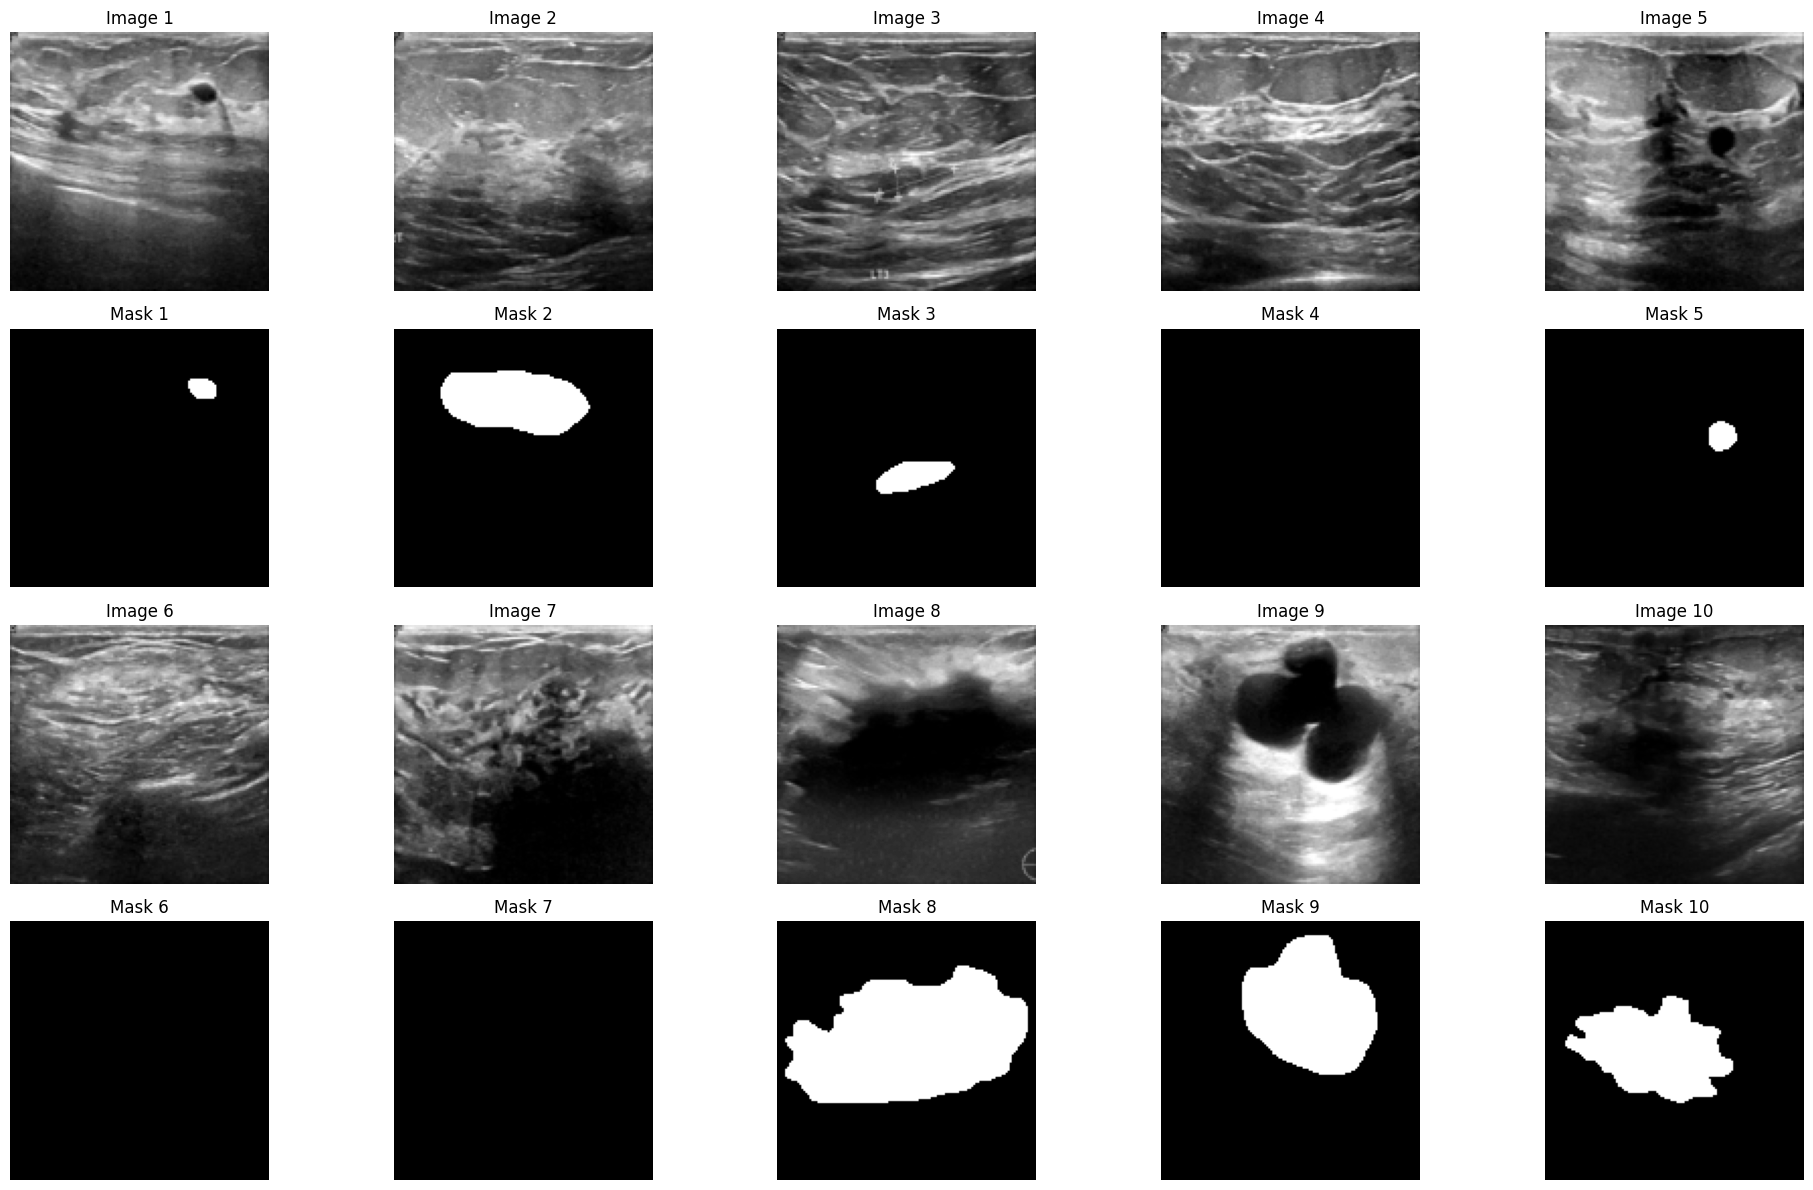

In [ ]:
# Total pairs to display
num_pairs = 10
indices = random.sample(range(len(X)), num_pairs)

fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(20, 12))
for i in range(5):
    # Display image on the top row
    axes[0, i].imshow(np.squeeze(X[indices[i]]), cmap='gray')
    axes[0, i].set_title(f"Image {i+1}")
    axes[0, i].axis('off')
    # Display corresponding mask on the second row
    axes[1, i].imshow(np.squeeze(Y[indices[i]]), cmap='gray')
    axes[1, i].set_title(f"Mask {i+1}")
    axes[1, i].axis('off')
for i in range(5, 10):
    # Display image on the third row (i-5 gives 0-index for this block)
    axes[2, i-5].imshow(np.squeeze(X[indices[i]]), cmap='gray')
    axes[2, i-5].set_title(f"Image {i+1}")
    axes[2, i-5].axis('off')
    # Display corresponding mask on the fourth row
    axes[3, i-5].imshow(np.squeeze(Y[indices[i]]), cmap='gray')
    axes[3, i-5].set_title(f"Mask {i+1}")
    axes[3, i-5].axis('off')

plt.tight_layout()
plt.show()

In [30]:
# Split the dataset into training and validation sets (90/10 split)
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.1, random_state=seed)

In [31]:
# Build the U-Net model using TensorFlow Keras
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
# s = tf.keras.layers.Lambda(lambda x: x/255)(inputs) # not needed, here already normalized

# Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

# Expansive path
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1])
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 128, 128,  │        160 │ input_layer_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 128, 128,  │          0 │ conv2d_19[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 128, 128,  │      2,320 │ dropout_9[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 64, 64,    │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 64, 64,    │      4,640 │ max_pooling2d_4[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 64, 64,    │          0 │ conv2d_21[0][0]   │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 64, 64,    │      9,248 │ dropout_10[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 32, 32,    │          0 │ conv2d_22[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 32, 32,    │     18,496 │ max_pooling2d_5[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 32, 32,    │          0 │ conv2d_23[0][0]   │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 32, 32,    │     36,928 │ dropout_11[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 16, 16,    │          0 │ conv2d_24[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 16, 16,    │     73,856 │ max_pooling2d_6[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 16, 16,    │          0 │ conv2d_25[0][0]   │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 16, 16,    │    147,584 │ dropout_12[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 8, 8, 128) │          0 │ conv2d_26[0][0] 

 Total params: 1,940,817 (7.40 MB)

 Trainable params: 1,940,817 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# add additional callbacks (ModelCheckpoint or EarlyStopping)

In [32]:
# Train the model
results = model.fit(X_train, Y_train, validation_data=(X_val, Y_val),
                    batch_size=16, epochs=10, verbose=1)

Epoch 1/10


c:\Users\abhil.LAPTOP-UDIMD39P\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_41']
Received: inputs=Tensor(shape=(None, 128, 128, 1))
  warnings.warn(msg)


37/37 ━━━━━━━━━━━━━━━━━━━━ 22s 360ms/step - accuracy: 0.8521 - loss: 0.5727 - val_accuracy: 0.9060 - val_loss: 0.3280
Epoch 2/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 13s 340ms/step - accuracy: 0.9064 - loss: 0.2918 - val_accuracy: 0.9060 - val_loss: 0.2689
Epoch 3/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 13s 341ms/step - accuracy: 0.9064 - loss: 0.2668 - val_accuracy: 0.9060 - val_loss: 0.2642
Epoch 4/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 13s 335ms/step - accuracy: 0.9064 - loss: 0.2505 - val_accuracy: 0.9060 - val_loss: 0.2479
Epoch 5/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 13s 336ms/step - accuracy: 0.9064 - loss: 0.2443 - val_accuracy: 0.9060 - val_loss: 0.2416
Epoch 6/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 13s 352ms/step - accuracy: 0.9065 - loss: 0.2320 - val_accuracy: 0.9150 - val_loss: 0.2416
Epoch 7/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 14s 371ms/step - accuracy: 0.9157 - loss: 0.2176 - val_accuracy: 0.9285 - val_loss: 0.2051
Epoch 8/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 13s 351ms/step - accuracy: 0.9264 - loss: 0.2007 - val_accuracy: 0.920

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


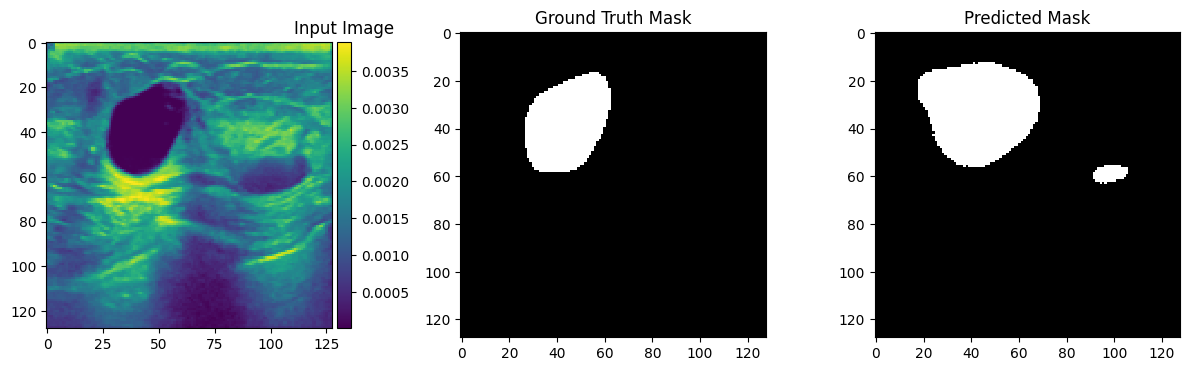

In [41]:
# Predict on a random training sample and visualize the results
ix = random.randint(0, len(X_train) - 1)
preds = model.predict(np.expand_dims(X_train[ix], axis=0))

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
imshow(np.squeeze(X_train[ix]))
plt.title("Input Image")
plt.subplot(1, 3, 2)
imshow(np.squeeze(Y_train[ix]))
plt.title("Ground Truth Mask")
plt.subplot(1, 3, 3)
# Threshold the predicted mask at 0.5
imshow(np.squeeze(preds[0] > 0.5))
plt.title("Predicted Mask")
plt.show()